In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
lst_years = []
for i in range(24):
    year = 2000 + i
    year = str(year)
    lst_years.append(year)

# Economic Conditions

In [3]:
excel_file = pd.ExcelFile('S&P_US.xlsx')

dfa = {}
for sheet_name in excel_file.sheet_names:
    dfa[sheet_name] = excel_file.parse(sheet_name)

df_sp_500 = dfa['S&P_500']
df_treasuries = dfa['US_Treasuries'][['year', 'average_yield']]
df_treasuries = df_treasuries.rename(columns={'average_yield':'US Treasuries'}) 
df_treasuries = df_treasuries.drop(df_treasuries.index[-1])

# S&P 500 Composite
df_sp_500['Next S&P 500'] = df_sp_500['S&P 500'].shift(1)
df_sp_500['year'] = df_sp_500['year'].shift(1)
df_sp_500['SP_500_return'] = (df_sp_500['Next S&P 500'] - df_sp_500['S&P 500']) / df_sp_500['S&P 500']
df_sp_500 = df_sp_500[['year', 'SP_500_return']].drop(0)
df_sp_500['year'] = df_sp_500['year'].astype(int)

lst_sp_500 = df_sp_500['SP_500_return'].to_list()
lst_treasuries = df_treasuries['US Treasuries'].to_list()

# Multi-factor Portfolio

## 1. Data Collection

In [4]:
excel_file = pd.ExcelFile('Data_Python.xlsx')

dfs = {}
for sheet_name in excel_file.sheet_names:
    dfs[sheet_name] = excel_file.parse(sheet_name)


for i in range(24):
    # Для замены пропущенных символов была взята медиана, а не среднее в целях сокращения влияния выбросов 
    df_reset = dfs[lst_years[i]].drop(["Symbol", "Company", "Sector"], axis=1).median()
    for column in df_reset.index:
        dfs[lst_years[i]][column].fillna(value=df_reset[column], inplace=True)
    dfs[lst_years[i]]['EV/EBITDA'] = dfs[lst_years[i]]['EV'] / dfs[lst_years[i]]['EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]].drop('Symbol', axis=1)
    column_order = ['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 'Beta', 'Market Value',
                    'Revenue', 'EBITDA', 'EV', 'Book Value', 'EPS', 'DPS', 'Dividend Yield', 'D/E', 'D/total Cap', 
                    'EV/EBITDA', 'Current Ratio', 'Quick Ratio', 'P/BV', 'P/E', 'ROA', 'ROE', 'ROIC', 
                    'Gross Profit margin', 'Operating profit margin', 'Net profit margin',
                    'EPS 1Y growth', 'EPS 3Y growth', 'EPS 5Y growth', 
                    '12M forward EPS', '12M forward Earn. Yield', 'fwd 12M EV/EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]][column_order]

In [5]:
df_ml_portfolio = pd.DataFrame()
df_ml_portfolio['year'] = lst_years[1:]

## 2. Models
### 2.1. Linear Regression

In [6]:
lin_reg = LinearRegression()
dict_lin_reg = {}
lin_reg_return = []

for i in range(23):
    df_first = dfs[lst_years[i]].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    df_first = df_first.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                          'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value'], axis = 1)
    
    X_train = df_first.drop(columns=['Return'], axis=1)
    y_train = df_first['Return']

    lin_reg.fit(X_train, y_train)
    
    df_second = dfs[lst_years[i + 1]].copy()
    df_sec = pd.DataFrame()
    df_sec['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    df_sec[['Company', 'Share price_cur', 'Share price_Y-1']] = df_second[['Company', 'Share price_cur', 'Share price_Y-1']]
    df_second = df_second.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                            'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value'], 
                                   axis = 1)
    
    X_test = df_second
    y_test = np.array(df_sec['Return'])

    y_pred = lin_reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  
    r2 = r2_score(y_test, y_pred) 
    
    pred_data = pd.DataFrame({'Company': df_sec['Company'], 
                              'Act_Return': df_sec['Return'], 
                              'Pred_Return': y_pred})

    lin_reg_portfolio = pred_data.sort_values(by='Pred_Return', ascending=False).head(10)
    dict_lin_reg[str(lst_years[i])] = list(lin_reg_portfolio.Company)

    merged_df = lin_reg_portfolio.merge(df_sec[['Company', 'Share price_cur', 'Share price_Y-1']], 
                                        how='inner', on='Company')

    p_return = (merged_df['Share price_cur'].sum() - merged_df['Share price_Y-1'].sum()) / merged_df['Share price_Y-1'].sum()
    lin_reg_return.append(p_return)
    
df_ml_portfolio['lin_reg'] = lin_reg_return

### 2.2. XGB Boost

In [7]:
xgb = XGBRegressor(
                    n_estimators=100,   # Количество деревьев (число итераций бустинга)
                    max_depth=3,        # Максимальная глубина деревьев
                    learning_rate=0.1,  # Скорость обучения (шаг градиентного спуска)
                    random_state=42)    # Зафиксируем random_state для воспроизводимости результатов
dict_xgb = {}
xgb_return = []

for i in range(23):
    df_first = dfs[lst_years[i]].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    df_first = df_first.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                          'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value'], axis = 1)
    
    X_train = df_first.drop(columns=['Return'], axis=1)
    y_train = df_first['Return']

    xgb.fit(X_train, y_train)
    
    df_second = dfs[lst_years[i + 1]].copy()
    df_sec = pd.DataFrame()
    df_sec['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    df_sec[['Company', 'Share price_cur', 'Share price_Y-1']] = df_second[['Company', 'Share price_cur', 'Share price_Y-1']]
    df_second = df_second.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                            'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value'], 
                                   axis = 1)
    
    X_test = df_second
    y_test = np.array(df_sec['Return'])

    y_pred = xgb.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  
    r2 = r2_score(y_test, y_pred) 
    
    pred_data = pd.DataFrame({'Company': df_sec['Company'], 
                              'Act_Return': df_sec['Return'], 
                              'Pred_Return': y_pred})

    xgb_portfolio = pred_data.sort_values(by='Pred_Return', ascending=False).head(10)
    dict_xgb[str(lst_years[i])] = list(xgb_portfolio.Company)

    merged_df = xgb_portfolio.merge(df_sec[['Company', 'Share price_cur', 'Share price_Y-1']], 
                                    how='inner', on='Company')

    p_return = (merged_df['Share price_cur'].sum() - merged_df['Share price_Y-1'].sum()) / merged_df['Share price_Y-1'].sum()
    xgb_return.append(p_return)
    
df_ml_portfolio['xgb'] = xgb_return

## 3. Return Analysis

In [8]:
df_ml_portfolio['SP_500'] = lst_sp_500
df_ml_portfolio['US_treasuries'] = lst_treasuries

In [9]:
df_ml_portfolio

,year,lin_reg,xgb,SP_500,US_treasuries
0,2001,0.064247,0.064209,0.242305,0.0396
1,2002,-0.111764,0.101363,-0.194428,0.0295
2,2003,0.301791,0.500708,0.268927,0.0145
3,2004,0.324320,0.086567,0.162589,0.0089
4,2005,0.116383,0.055940,0.288781,0.0214
5,2006,-0.095666,0.620056,-0.062373,0.0291
6,2007,0.449348,0.745898,0.194200,0.0233
7,2008,-0.317525,-0.340147,0.095350,0.0184
8,2009,0.026605,-0.022515,-0.007266,0.0214
9,2010,0.543536,0.429051,0.113906,0.0254


In [10]:
df_ml_portfolio.drop(columns=['year'], axis=1).mean()

lin_reg          0.118014
xgb              0.270064
SP_500           0.073943
US_treasuries    0.031239
dtype: float64

In [11]:
df_ml_portfolio_cum = df_ml_portfolio.set_index('year').cumsum(axis=0).reset_index()
df_ml_portfolio_cum

,year,lin_reg,xgb,SP_500,US_treasuries
0,2001,0.064247,0.064209,0.242305,0.0396
1,2002,-0.047517,0.165572,0.047877,0.0691
2,2003,0.254274,0.666280,0.316804,0.0836
3,2004,0.578594,0.752847,0.479393,0.0925
4,2005,0.694977,0.808786,0.768174,0.1139
5,2006,0.599311,1.428842,0.705801,0.1430
6,2007,1.048660,2.174741,0.900001,0.1663
7,2008,0.731135,1.834593,0.995351,0.1847
8,2009,0.757740,1.812078,0.988085,0.2061
9,2010,1.301275,2.241129,1.101992,0.2315


In [12]:
df_ml_portfolio_cum.tail(1)

,year,lin_reg,xgb,SP_500,US_treasuries
22,2023,2.714312,6.211472,1.70069,0.7185


In [13]:
# Сохранение DataFrame в Excel на разные листы

with pd.ExcelWriter('results_10.xlsx', mode='a', engine='openpyxl') as writer:
    df_ml_portfolio.to_excel(writer, sheet_name='ml_portfolio')
    df_ml_portfolio_cum.to_excel(writer, sheet_name='ml_portfolio_cum')

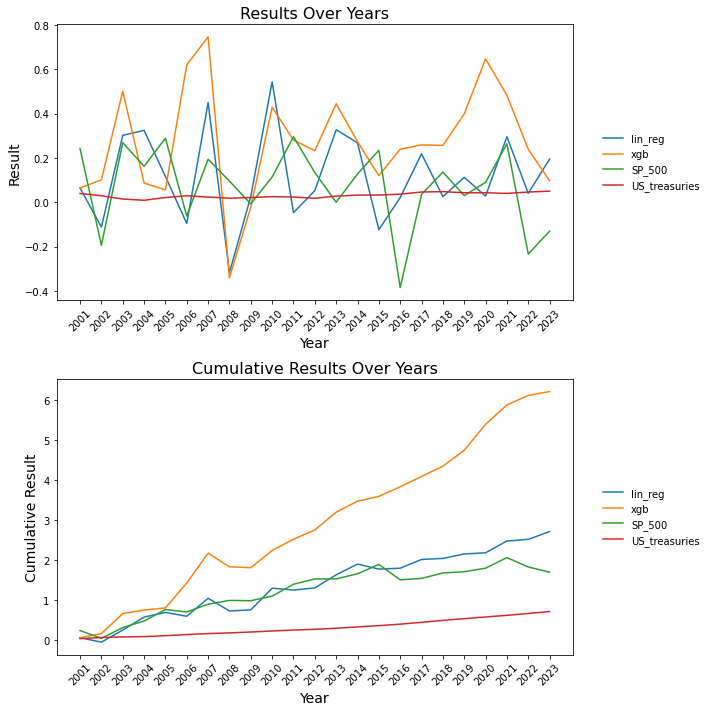

In [14]:
df_ml_portfolio.set_index('year', inplace=True)
df_ml_portfolio_cum.set_index('year', inplace=True)

df_ml_portfolio.index = df_ml_portfolio.index.astype(int)
df_ml_portfolio_cum.index = df_ml_portfolio_cum.index.astype(int)

# горизонтальное расположение
#fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# вертикальное расположение
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Построим график для обычных результатов
df_ml_portfolio.plot(ax=axs[0], kind='line')
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Result', fontsize=14)
axs[0].set_title('Results Over Years', fontsize=16)
axs[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[0].set_xticks(df_ml_portfolio.index)
axs[0].set_xticklabels(df_ml_portfolio.index, rotation=45)

# Построим график для кумулятивных результатов
df_ml_portfolio_cum.plot(ax=axs[1], kind='line')
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Cumulative Result', fontsize=14)
axs[1].set_title('Cumulative Results Over Years', fontsize=16)
axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[1].set_xticks(df_ml_portfolio_cum.index)
axs[1].set_xticklabels(df_ml_portfolio_cum.index, rotation=45)

plt.tight_layout()
plt.show()

<div style="border-bottom: 5px solid black;"></div>

# Multi-factor Portfolio w/ Sector Adjustment

## 1. Data Collection

In [15]:
excel_file = pd.ExcelFile('Data_Python.xlsx')

dfs = {}
for sheet_name in excel_file.sheet_names:
    dfs[sheet_name] = excel_file.parse(sheet_name)


for i in range(24):
    # Для замены пропущенных символов была взята медиана, а не среднее в целях сокращения влияния выбросов 
    df_reset = dfs[lst_years[i]].drop(["Symbol", "Company", "Sector"], axis=1).median()
    for column in df_reset.index:
        dfs[lst_years[i]][column].fillna(value=df_reset[column], inplace=True)
    dfs[lst_years[i]]['EV/EBITDA'] = dfs[lst_years[i]]['EV'] / dfs[lst_years[i]]['EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]].drop('Symbol', axis=1)
    column_order = ['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 'Beta', 'Market Value',
                    'Revenue', 'EBITDA', 'EV', 'Book Value', 'EPS', 'DPS', 'Dividend Yield', 'D/E', 'D/total Cap', 
                    'EV/EBITDA', 'Current Ratio', 'Quick Ratio', 'P/BV', 'P/E', 'ROA', 'ROE', 'ROIC', 
                    'Gross Profit margin', 'Operating profit margin', 'Net profit margin',
                    'EPS 1Y growth', 'EPS 3Y growth', 'EPS 5Y growth', 
                    '12M forward EPS', '12M forward Earn. Yield', 'fwd 12M EV/EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]][column_order]

In [16]:
df_ml_portfolio_adj = pd.DataFrame()
df_ml_portfolio_adj['year'] = lst_years[1:]

## 2. Models
### 2.1. Linear Regression

In [17]:
lin_reg = LinearRegression()
dict_lin_reg_adj = {}
lin_reg_return_adj = []

for i in range(23):
    df_first = dfs[lst_years[i]].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    encoded_df = pd.get_dummies(df_first['Sector'])
    df_enc_first = pd.concat([df_first, encoded_df], axis=1)
    df_first = df_enc_first.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                          'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value'], axis = 1)
    
    X_train = df_first.drop(columns=['Return'], axis=1)
    y_train = df_first['Return']

    lin_reg.fit(X_train, y_train)
    
    df_second = dfs[lst_years[i + 1]].copy()
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    encoded_df = pd.get_dummies(df_second['Sector'])
    df_enc_second = pd.concat([df_second, encoded_df], axis=1)
    df_second = df_enc_second.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                            'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value', 'Return'], 
                                   axis = 1)
    
    X_test = df_second
    y_test = np.array(df_enc_second['Return'])

    y_pred = lin_reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  
    r2 = r2_score(y_test, y_pred) 
    
    pred_data = pd.DataFrame({'Company': df_enc_second['Company'], 
                              'Act_Return': df_enc_second['Return'], 
                              'Pred_Return': y_pred})

    lin_reg_portfolio_adj = pred_data.sort_values(by='Pred_Return', ascending=False).head(10)
    dict_lin_reg_adj[str(lst_years[i])] = list(lin_reg_portfolio_adj.Company)

    merged_df = lin_reg_portfolio_adj.merge(df_enc_second[['Company', 'Share price_cur', 'Share price_Y-1']], 
                                        how='inner', on='Company')

    p_return = (merged_df['Share price_cur'].sum() - merged_df['Share price_Y-1'].sum()) / merged_df['Share price_Y-1'].sum()
    lin_reg_return_adj.append(p_return)
    
df_ml_portfolio_adj['lin_reg'] = lin_reg_return_adj

### 2.2. XGB Boost

In [18]:
xgb = XGBRegressor(
                    n_estimators=100,   # Количество деревьев (число итераций бустинга)
                    max_depth=3,        # Максимальная глубина деревьев
                    learning_rate=0.1,  # Скорость обучения (шаг градиентного спуска)
                    random_state=42)    # Зафиксируем random_state для воспроизводимости результатов
dict_xgb_adj = {}
xgb_return_adj = []

for i in range(23):
    df_first = dfs[lst_years[i]].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    encoded_df = pd.get_dummies(df_first['Sector'])
    df_enc_first = pd.concat([df_first, encoded_df], axis=1)
    df_first = df_enc_first.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                          'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value'], axis = 1)
    
    X_train = df_first.drop(columns=['Return'], axis=1)
    y_train = df_first['Return']

    xgb.fit(X_train, y_train)
    
    df_second = dfs[lst_years[i + 1]].copy()
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    encoded_df = pd.get_dummies(df_second['Sector'])
    df_enc_second = pd.concat([df_second, encoded_df], axis=1)
    df_second = df_enc_second.drop(columns=['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 
                                            'Market Value', 'Revenue', 'EBITDA', 'EV', 'Book Value', 'Return'], 
                                   axis = 1)
    
    X_test = df_second
    y_test = np.array(df_enc_second['Return'])

    y_pred = xgb.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  
    r2 = r2_score(y_test, y_pred) 
    
    pred_data = pd.DataFrame({'Company': df_enc_second['Company'], 
                              'Act_Return': df_enc_second['Return'], 
                              'Pred_Return': y_pred})

    xgb_portfolio_adj = pred_data.sort_values(by='Pred_Return', ascending=False).head(10)
    dict_xgb_adj[str(lst_years[i])] = list(xgb_portfolio_adj.Company)

    merged_df = xgb_portfolio_adj.merge(df_enc_second[['Company', 'Share price_cur', 'Share price_Y-1']], 
                                        how='inner', on='Company')

    p_return = (merged_df['Share price_cur'].sum() - merged_df['Share price_Y-1'].sum()) / merged_df['Share price_Y-1'].sum()
    xgb_return_adj.append(p_return)
    
df_ml_portfolio_adj['xgb'] = xgb_return_adj

## 3. Return Analysis

In [19]:
df_ml_portfolio_adj['SP_500'] = lst_sp_500
df_ml_portfolio_adj['US_treasuries'] = lst_treasuries

In [20]:
df_ml_portfolio_adj

,year,lin_reg,xgb,SP_500,US_treasuries
0,2001,0.057195,0.064142,0.242305,0.0396
1,2002,-0.138606,0.101363,-0.194428,0.0295
2,2003,0.288111,0.500708,0.268927,0.0145
3,2004,0.295241,0.088148,0.162589,0.0089
4,2005,0.131888,0.055940,0.288781,0.0214
5,2006,-0.096149,0.408720,-0.062373,0.0291
6,2007,0.449348,1.652918,0.194200,0.0233
7,2008,-0.317633,-0.231880,0.095350,0.0184
8,2009,0.026809,0.002173,-0.007266,0.0214
9,2010,0.516100,0.407958,0.113906,0.0254


In [21]:
df_ml_portfolio_adj.drop(columns=['year'], axis=1).mean()

lin_reg          0.120315
xgb              0.302871
SP_500           0.073943
US_treasuries    0.031239
dtype: float64

In [22]:
df_ml_portfolio_cum_adj = df_ml_portfolio_adj.set_index('year').cumsum(axis=0).reset_index()
df_ml_portfolio_cum_adj

,year,lin_reg,xgb,SP_500,US_treasuries
0,2001,0.057195,0.064142,0.242305,0.0396
1,2002,-0.081411,0.165505,0.047877,0.0691
2,2003,0.206700,0.666213,0.316804,0.0836
3,2004,0.501941,0.754361,0.479393,0.0925
4,2005,0.633829,0.810301,0.768174,0.1139
5,2006,0.537680,1.219021,0.705801,0.1430
6,2007,0.987029,2.871939,0.900001,0.1663
7,2008,0.669396,2.640059,0.995351,0.1847
8,2009,0.696205,2.642232,0.988085,0.2061
9,2010,1.212305,3.050189,1.101992,0.2315


In [23]:
df_ml_portfolio_cum_adj.tail(1)

,year,lin_reg,xgb,SP_500,US_treasuries
22,2023,2.767251,6.966028,1.70069,0.7185


In [24]:
# Сохранение DataFrame в Excel на разные листы
with pd.ExcelWriter('results_10.xlsx', mode='a', engine='openpyxl') as writer:
    df_ml_portfolio_adj.to_excel(writer, sheet_name='ml_portfolio_adj')
    df_ml_portfolio_cum_adj.to_excel(writer, sheet_name='ml_portfolio_cum_adj')

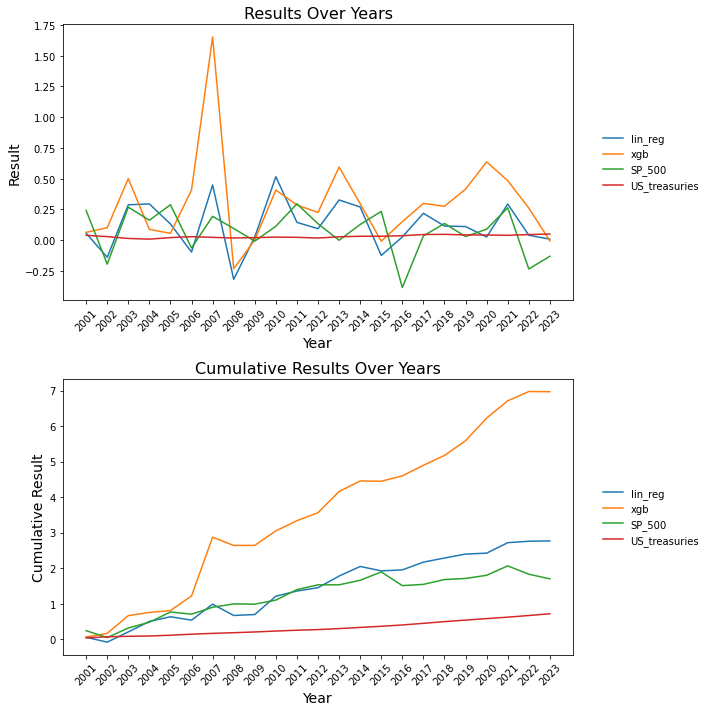

In [25]:
df_ml_portfolio_adj.set_index('year', inplace=True)
df_ml_portfolio_cum_adj.set_index('year', inplace=True)

df_ml_portfolio_adj.index = df_ml_portfolio_adj.index.astype(int)
df_ml_portfolio_cum_adj.index = df_ml_portfolio_cum_adj.index.astype(int)

# горизонтальное расположение
#fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# вертикальное расположение
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Построим график для обычных результатов
df_ml_portfolio_adj.plot(ax=axs[0], kind='line')
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Result', fontsize=14)
axs[0].set_title('Results Over Years', fontsize=16)
axs[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[0].set_xticks(df_ml_portfolio_adj.index)
axs[0].set_xticklabels(df_ml_portfolio_adj.index, rotation=45)

# Построим график для кумулятивных результатов
df_ml_portfolio_cum_adj.plot(ax=axs[1], kind='line')
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Cumulative Result', fontsize=14)
axs[1].set_title('Cumulative Results Over Years', fontsize=16)
axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[1].set_xticks(df_ml_portfolio_cum_adj.index)
axs[1].set_xticklabels(df_ml_portfolio_cum_adj.index, rotation=45)

plt.tight_layout()
plt.show()